In [1]:
# By - AKSHIT NETAR 

# STEP 1 = Importing important libraries

from datetime import datetime
import numpy as np             # for numerical computations like log,exp,sqrt etc
import pandas as pd            # for reading & storing data, pre-processing
import matplotlib.pylab as plt # for visualization

#for making sure matplotlib plots are generated in Jupyter notebook itself ---
%matplotlib inline       

from statsmodels.tsa.stattools import adfuller      # For Dickey Fuller Test
from statsmodels.tsa.stattools import acf, pacf     # For ACF and PACF Charts
from statsmodels.tsa.seasonal import seasonal_decompose  
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
# STEP 2 = Reading and Visualisation of Given dataset

#Reading the data from input file
dataset = pd.read_csv('traffic_data.csv')

#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True)

#convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)     # It will show the initial 5 data points in our datasheet

,#Number of vehicles
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


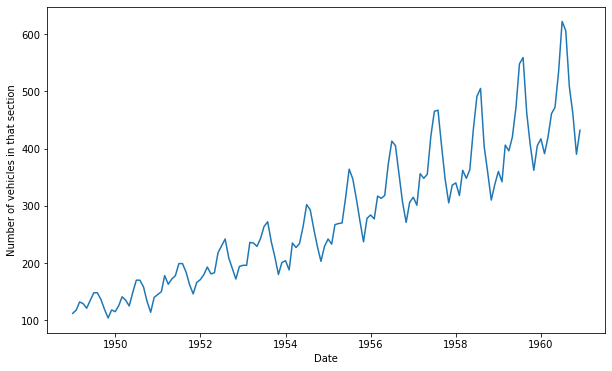

In [3]:
# Visualizing the data - by plotting graph
plt.xlabel('Date')
plt.ylabel('Number of vehicles in that section')
plt.plot(indexedDataset)    # It will show the orignal data series 

In [4]:
#STEP 3 = Determination of Rolling Mean and Rolling Standard Deviation for Rolling Window
#Determine rolling statistics - i.e, Rolling Mean and Rolling Standard Deviation for window size =12 months
rolling_mean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolling_std = indexedDataset.rolling(window=12).std()
print(rolling_mean,rolling_std)

            #Number of vehicles
Month                          
1949-01-01                  NaN
1949-02-01                  NaN
1949-03-01                  NaN
1949-04-01                  NaN
1949-05-01                  NaN
...                         ...
1960-08-01           463.333333
1960-09-01           467.083333
1960-10-01           471.583333
1960-11-01           473.916667
1960-12-01           476.166667

[144 rows x 1 columns]             #Number of vehicles
Month                          
1949-01-01                  NaN
1949-02-01                  NaN
1949-03-01                  NaN
1949-04-01                  NaN
1949-05-01                  NaN
...                         ...
1960-08-01            83.630500
1960-09-01            84.617276
1960-10-01            82.541954
1960-11-01            79.502382
1960-12-01            77.737125

[144 rows x 1 columns]


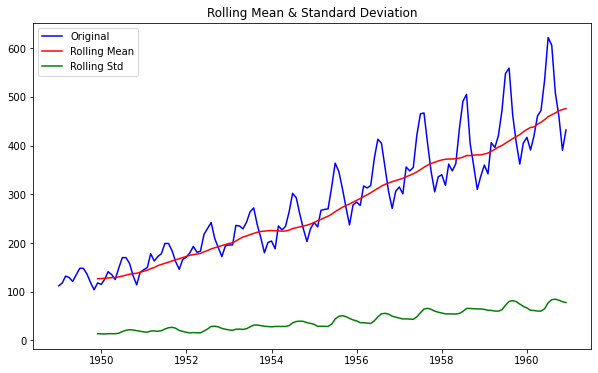

In [5]:
# STEP 4 = Checking for the stationarity of data by Visualisation

#Plot rolling statistics
orig_series = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)



In [6]:
# Summary on Stationarity of given dataset based on visual observation
'''
From the above graph, 
We see that rolling mean has a trend component which is increasing with time 
and rolling standard deviation is almost constant with time. 
We know that,For our time series to be stationary, both the rolling statistics ie: mean & std. dev. should 
remain time invariant. Therefore the above graph shows that it is not stationary. 

To further prove that the time series is not stationary, we are going to perform the ADCF test.
'''
#STEP 6 = Confirmation of Non-Stationarity using ADCF Test

#Performing Augmented Dickey–Fuller test :

'''
For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values 
are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

'''
print('Results of Dickey Fuller Test:')
adftest = adfuller(indexedDataset['#Number of vehicles'], autolag='AIC')

adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
    
print(adfoutput)



Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


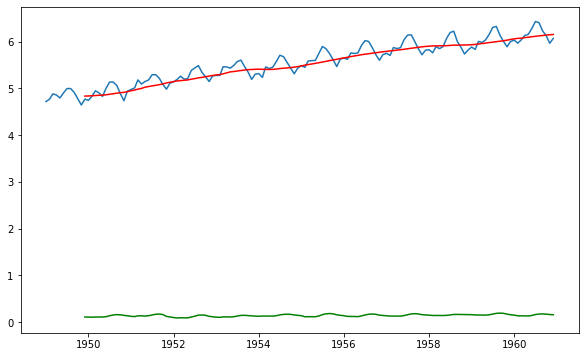

In [7]:
#STEP 7 = Transformation of given data to achieve Stationarity

'''
In our notebook, we are doing log transformations . 
We aim to remove the trend component. 

'''

# Log scale transformation
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.plot(movingSTD, color='green')



In [8]:
#STEP 8 = Achieving Stationarity through differencing
'''

We know from above graph that both the Time series with log scale as well as its
moving average have a trend component. 
Thus we can apply a differencing:
subtraction one from the other should remove the trend component of both. Its like:

Thus trend component will be almost removed.

'''

datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Removing NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Number of vehicles
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [9]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Performing Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Number of vehicles'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

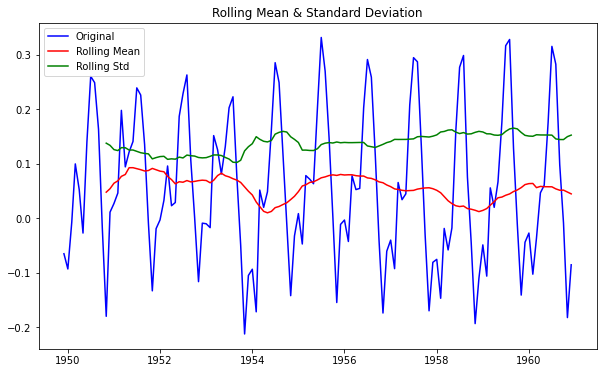

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [10]:
test_stationarity(datasetLogScaleMinusMovingAverage)

In [11]:
'''
From above graph,

p-value has reduced from 0.99 to 0.022.
The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus,from
above 2 points, we can say that our given series is stationary now.
'''

'\nFrom above graph,\n\np-value has reduced from 0.99 to 0.022.\nThe critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus,from\nabove 2 points, we can say that our given series is stationary now.\n'

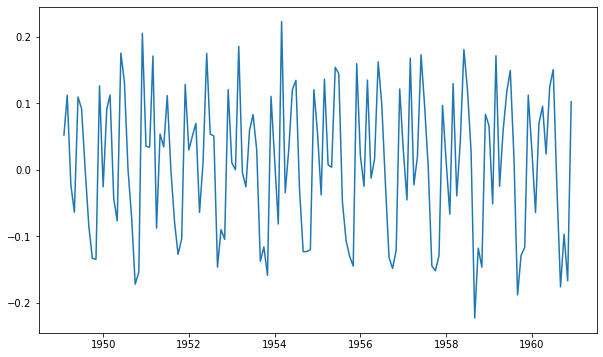

In [12]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

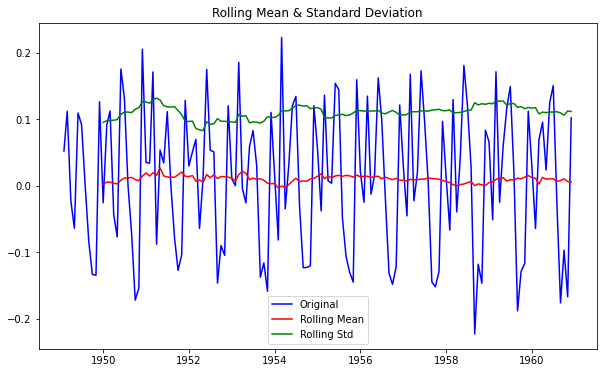

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [13]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

C:\Users\AKSHIT NETAR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


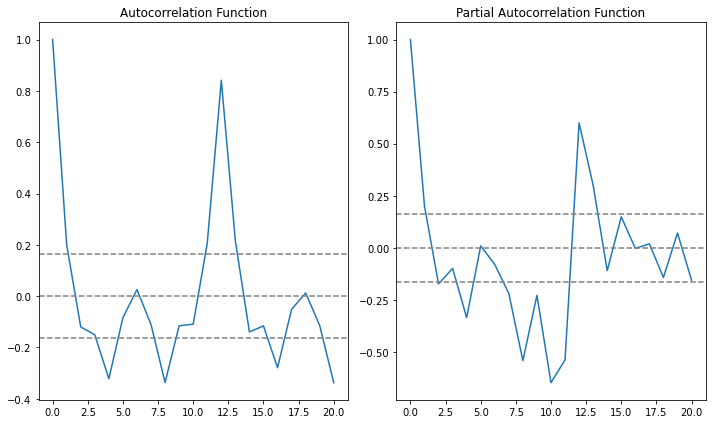

In [14]:
'''
The ADCF test above shows us that:

p-value of 0.07 is not as good as 0.005 of exponential decay.
Test Statistic value not as close to the critical values as that for exponential decay.
For simplicity,
we will go with the log scale. The reason for doing this is that we can revert back to the original
scale during forecasting.

'''
# STEP 9 = ACF and PACF plots to determine the parameters for our ARIMA Model. 
# ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plotting ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

In [15]:
'''
From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus,
from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 
line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. 

'''

'\nFrom the ACF graph, we see that curve touches y=0.0 line at x=2. Thus,\nfrom theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 \nline at x=2. Thus, from theory, P = 2\n\nARIMA is AR + I + MA. \n\n'

C:\Users\AKSHIT NETAR\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\AKSHIT NETAR\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting ARIMA model


C:\Users\AKSHIT NETAR\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


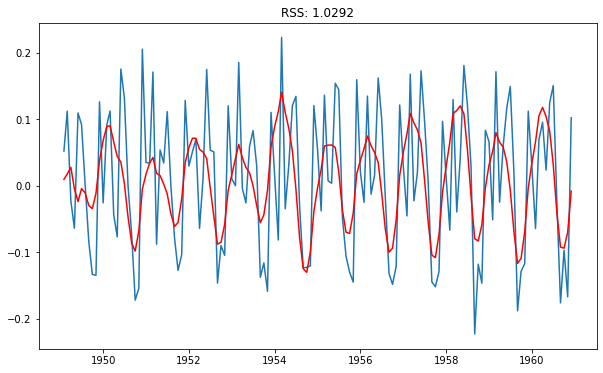

In [16]:
# STEP 10: ARIMA MODEL p =2, d=1, q =2 to be fitted on training data set
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Number of vehicles'])**2))
print('Plotting ARIMA model')

In [17]:
# STEP 11 = Conversion to Original Form

'''

With the ARIMA model built, we can now make predictions. But, before we do any
plots for predictions ,we need to reconvert the predictions back to original form because 
our model was built on log transformed data.

'''

'\n\nWith the ARIMA model built, we can now make predictions. But, before we do any\nplots for predictions ,we need to reconvert the predictions back to original form because \nour model was built on log transformed data.\n\n'

In [18]:
#Prediction & Reverse transformations
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [19]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372552
1960-09-01    1.280202
1960-10-01    1.186189
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64


In [20]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Number of vehicles'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

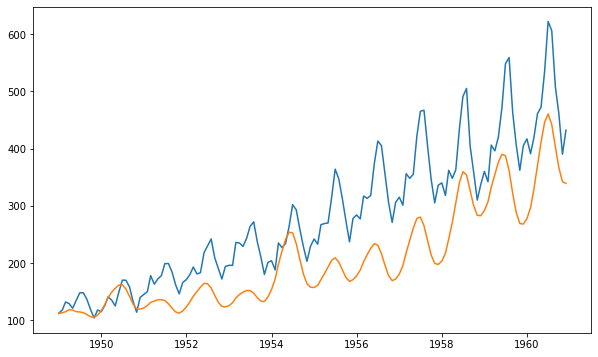

In [21]:
# STEP 12 = Comparison of our trained Model with the available original data

# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [22]:
indexedDataset_logScale

,#Number of vehicles
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


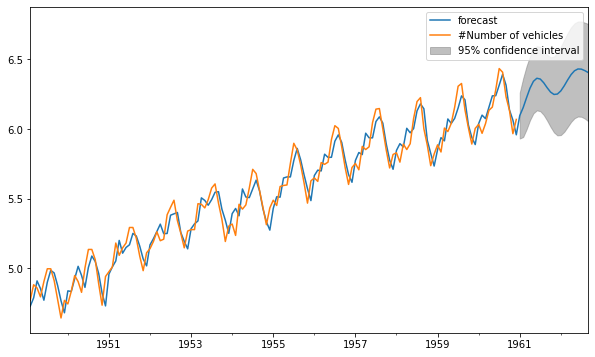

In [23]:
# STEP 13 = Making Forecasts for 120 months in future i.e. for 10 total years
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,164) 
x=results_ARIMA.forecast(steps=120)

In [24]:
# The good overlap between the 2 curves indicate a best fit Model for the forecasting. Therefore our Model ARIMA(2,1,2)
# is the best fit model for the given timeseries.